In [1]:
import numpy as np

from scipy.io import readsav

import matplotlib.pyplot as plt
import matplotlib.dates as date
from datetime import datetime
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cmasher as cmr

In [2]:
import scienceplots
plt.rcParams.update({'font.size': 14})
plt.style.use(['bright'])

Import Si IV data

In [3]:
fn = 'siiv_windat_f1.sav'
ro = readsav(fn, verbose=False, python_dict=False)


In [4]:
dat = ro.d['INT'][0]
wvl = ro.d['WVL'][0]
err = ro.d['ERR'][0]
arcsec = ro.d['SOLAR_Y'][0]

# seconds for fitting
t_iris =  ro.d['time'][0]

# datetime obj for plotting
time_iris = ro.d['time_ccsds'][0]
    
tm_iris = []
for t in time_iris:
    datetime_object = datetime.strptime(t.decode("utf-8"), '%Y-%m-%dT%H:%M:%S.%f')
    tm_iris.append(date.date2num(datetime_object))
tm_iris=np.array(tm_iris)

In [5]:
# wavelength reductions

siiv_lab = 1402.77
siiv_cen = siiv_lab

x1,x2 = 1402.25,1404.25 
wvl_lim, = np.where((wvl >= x1) & (wvl <= x2))
lam = wvl[wvl_lim]
siiv = dat[:,:,wvl_lim]
siiv_err = err[:,:,wvl_lim]

dlam=np.unique(np.diff(lam))[0]
print('dlam: ',dlam)

dlam:  0.02543999999738844


Moment Calculation:

In [6]:
#x1,x2 = 1401.,1404. 
x1,x2 = 1401.5,1404. 
wvl_lim, = np.where((wvl >= x1) & (wvl <= x2))
lam2 = wvl[wvl_lim]
siiv2 = dat[:,:,wvl_lim]

In [7]:
Npx,Ntm = siiv.shape[0],siiv.shape[1]
m0 = np.zeros((Npx,Ntm))
m1 = np.full((Npx, Ntm), siiv_cen)
m2 = np.zeros((Npx,Ntm))
m3 = np.zeros((Npx,Ntm))


for j in range(0,Ntm):
    for i in range(0,Npx):
        
        yt = np.copy(siiv2[i,j])
        #yt_err = siiv_err[i,j]
        yt[yt<25]=0.0
        
        zeros = np.zeros(shape=yt.shape)
        if yt.min()==-200.: yt = zeros
        
        
        # define moments
        m0t = np.sum( yt ) * dlam
        m1t = np.sum( yt*lam2 )/m0t * dlam
        if m0t<1.: 
            m0t=1.
            m1t=siiv_cen
        
        
        m0[i,j] = m0t
        m1[i,j] = m1t
        m2[i,j] = np.sum( yt*(lam2-m1t)**2 )/m0t * dlam
        m3[i,j] = np.sum( yt*(lam2-m1t)**3 )/m0t * dlam
    

/var/folders/2q/x6gt3v916vbdf_5s65b5jrdc000svr/T/ipykernel_12992/3920431508.py:21: RuntimeWarning: invalid value encountered in scalar divide
  m1t = np.sum( yt*lam2 )/m0t * dlam


Conversions:

In [8]:
vel = (m1-siiv_cen)/siiv_cen*3e5 # Doppler 

# thermal width
thermal_wid=[4.9,28.]
th_temp=10.**thermal_wid[0]
th_massnum=thermal_wid[1]* 1.661e-27 #SI


kb = 1.381e-23 #SI
c = 3e5 #; km/s
th_wid =  siiv_cen * np.sqrt( kb * (th_temp) / th_massnum)/(c*1e3)
th_fwhm = np.sqrt(8*np.log(2))*th_wid
th_wid_vel = 0.5/np.sqrt(np.log(2.))*3e5/siiv_cen*th_fwhm 
print('thermal width: ',th_wid, ' = ', th_wid_vel, 'km/s')

# instrumental width 
iris_wid = 0.026

# quadrature - Single
m2[m2<0] = 0.0
fwhm = 2.*np.sqrt(2.*np.log(2.)) * np.sqrt(m2)
chck = fwhm**2 - iris_wid**2 - th_wid**2
chck[chck<0]=0.
w_nth = np.sqrt(chck)

v_nth = 0.5/np.sqrt(np.log(2.))*3e5/siiv_cen*m2 # velocity transform

thermal width:  0.022709011071788025  =  6.868280212537351 km/s


In [9]:
m0_siiv = m0
m1vel_siiv = vel

In [10]:
#%store m0_siiv
#%store m1vel_siiv

fit results

In [11]:
tms = np.arange(10,920)
ns = len(tms)
colors = plt.cm.jet_r(np.linspace(0, 1, ns))
pxs = np.arange(139,148)

m0t = m0[:,tms]
m1t = m1[:,tms]
m2t = m2[:,tms]

m0s = m0[pxs[0]:pxs[-1]+1,tms]
m1s = m1[pxs[0]:pxs[-1]+1,tms]
m2s = m2[pxs[0]:pxs[-1]+1,tms]

vels = vel[pxs[0]:pxs[-1]+1,tms]
fwhms = fwhm[pxs[0]:pxs[-1]+1,tms]

In [12]:
px = 24

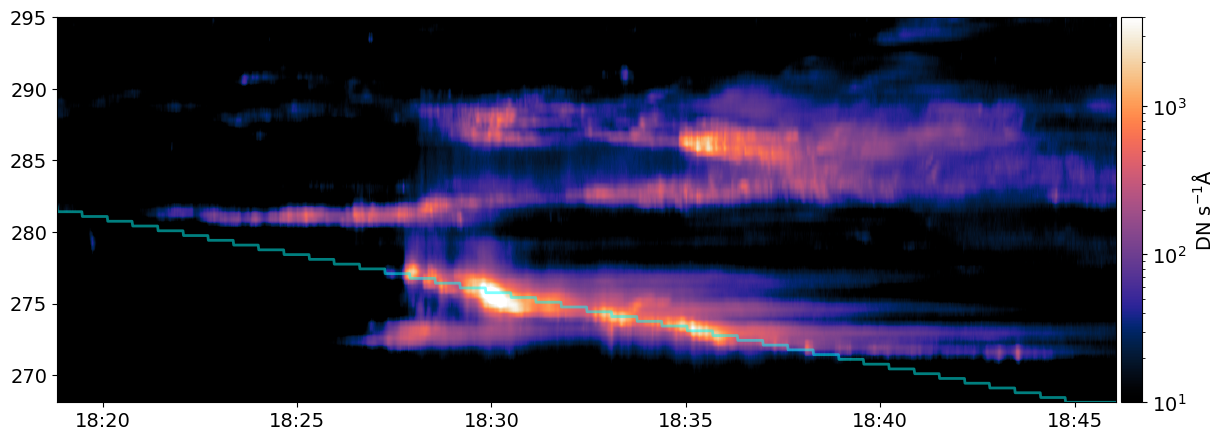

In [13]:
#m = -0.023
#b = 43

m = -0.021
b = 41

x_coords = np.arange(m0.shape[1])
y_coords = m * x_coords + b
y_coords = np.clip(y_coords, 0, m0.shape[0] - 1).astype(int)


fig, ax = plt.subplots(figsize=(14,5))

im = ax.imshow(m0,origin='lower',norm=LogNorm(vmin=10, vmax=4000),cmap=cmr.torch,aspect='auto',
          extent=[tm_iris[0],tm_iris[-1],arcsec[0],arcsec[-1]])

# color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('DN s$^{-1} \mathrm{\AA}$')

# date stuff
ax.xaxis_date()
date_format = date.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.set_ylim(top=295)


#ax.axhline(arcsec[px],linestyle='dashed',color='cyan',linewidth=3)

ax.plot(tm_iris, arcsec[y_coords], linewidth=2, label=f'y = {m}x + {b}',color='cyan',alpha=0.5)


In [14]:
#fig.savefig('siiv_m0.pdf', format='pdf', edgecolor='w',facecolor='w',bbox_inches='tight')

In [15]:
m0.shape

(203, 2001)

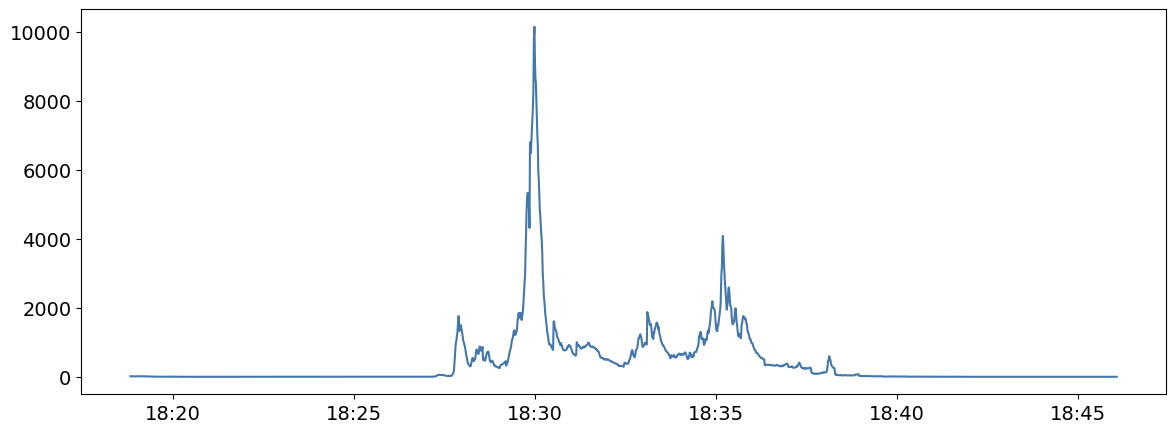

In [15]:
int_slice = m0[y_coords, x_coords]

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(tm_iris,int_slice)

ax.xaxis_date()
date_format = date.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)

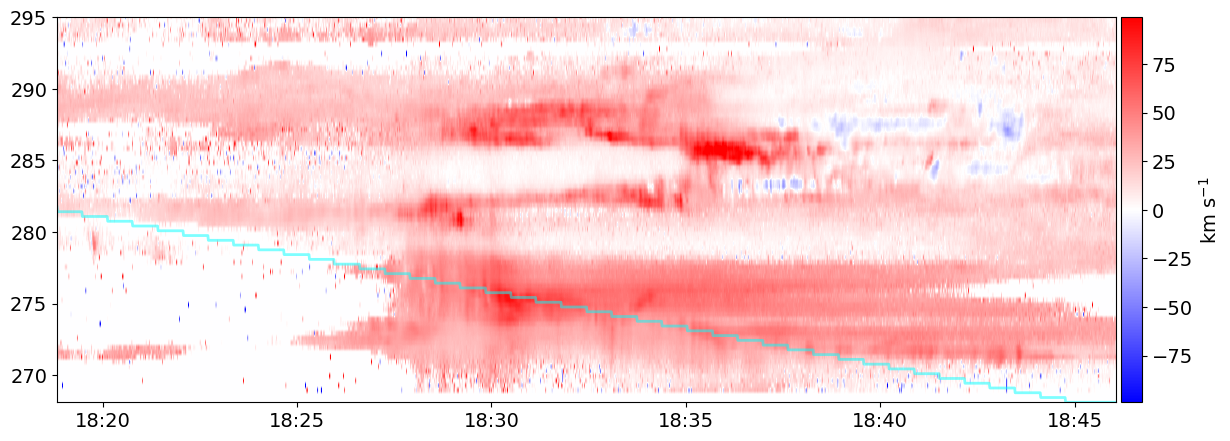

In [16]:
fig, ax = plt.subplots(figsize=(14,5))
im = ax.imshow(vel ,vmin=-99, vmax=99, origin='lower',aspect='auto',cmap='bwr',
          extent=[tm_iris[0],tm_iris[-1],arcsec[0],arcsec[-1]])

# color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('km s$^{-1}$')

# date stuff
ax.xaxis_date()
date_format = date.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.set_ylim(top=295)
#ax.set_xlim(left=tm_iris[0])

ax.plot(tm_iris, arcsec[y_coords], color='cyan', linewidth=2, label=f'y = {m}x + {b}',alpha=0.5)


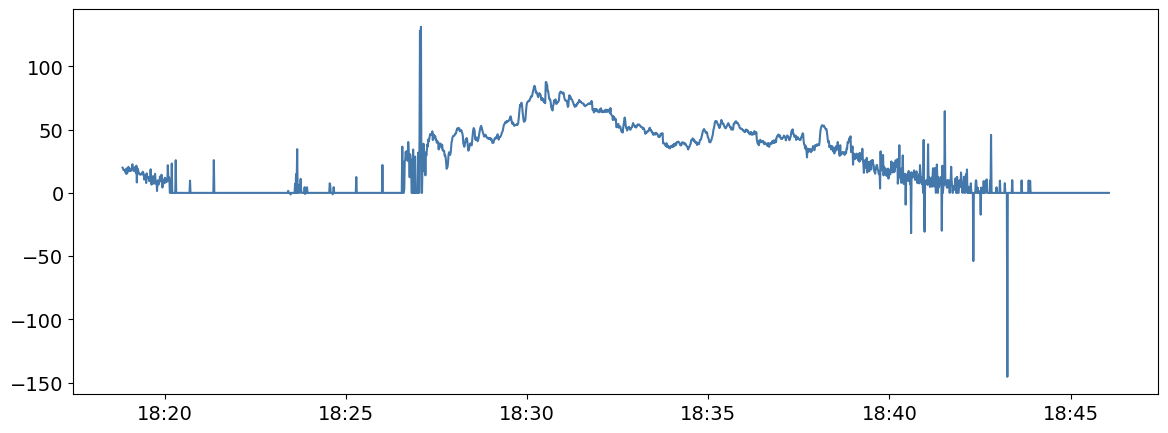

In [17]:
vel_slice = vel[y_coords, x_coords]
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(tm_iris,vel_slice)

ax.xaxis_date()
date_format = date.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)

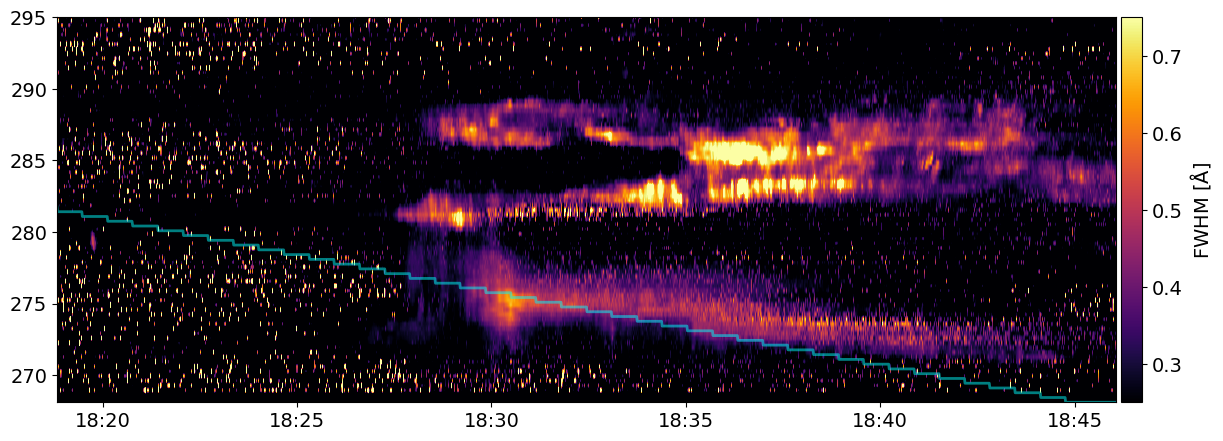

In [18]:
fig, ax = plt.subplots(figsize=(14,5))
#im = ax.imshow(v_nth ,vmin=0, vmax=30, origin='lower',aspect='auto',cmap='inferno',
im = ax.imshow(fwhm ,vmin=0.25, vmax=0.75, origin='lower',aspect='auto',cmap='inferno',
          extent=[tm_iris[0],tm_iris[-1],arcsec[0],arcsec[-1]])

# color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('FWHM [$\mathrm{\AA}$]')

# date stuff
ax.xaxis_date()
date_format = date.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.set_ylim(top=295)
#ax.set_xlim(left=tm_iris[0])

ax.plot(tm_iris, arcsec[y_coords], color='cyan', linewidth=2, label=f'y = {m}x + {b}',alpha=0.5)


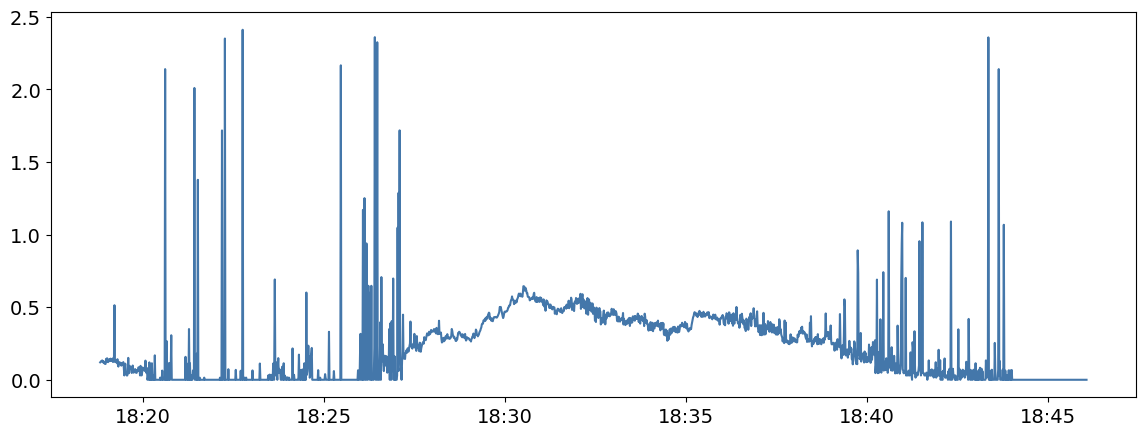

In [19]:
vnth_slice = fwhm[y_coords, x_coords]
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(tm_iris,vnth_slice)

ax.xaxis_date()
date_format = date.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)

Text(0, 0.5, 'y [arcsec]')

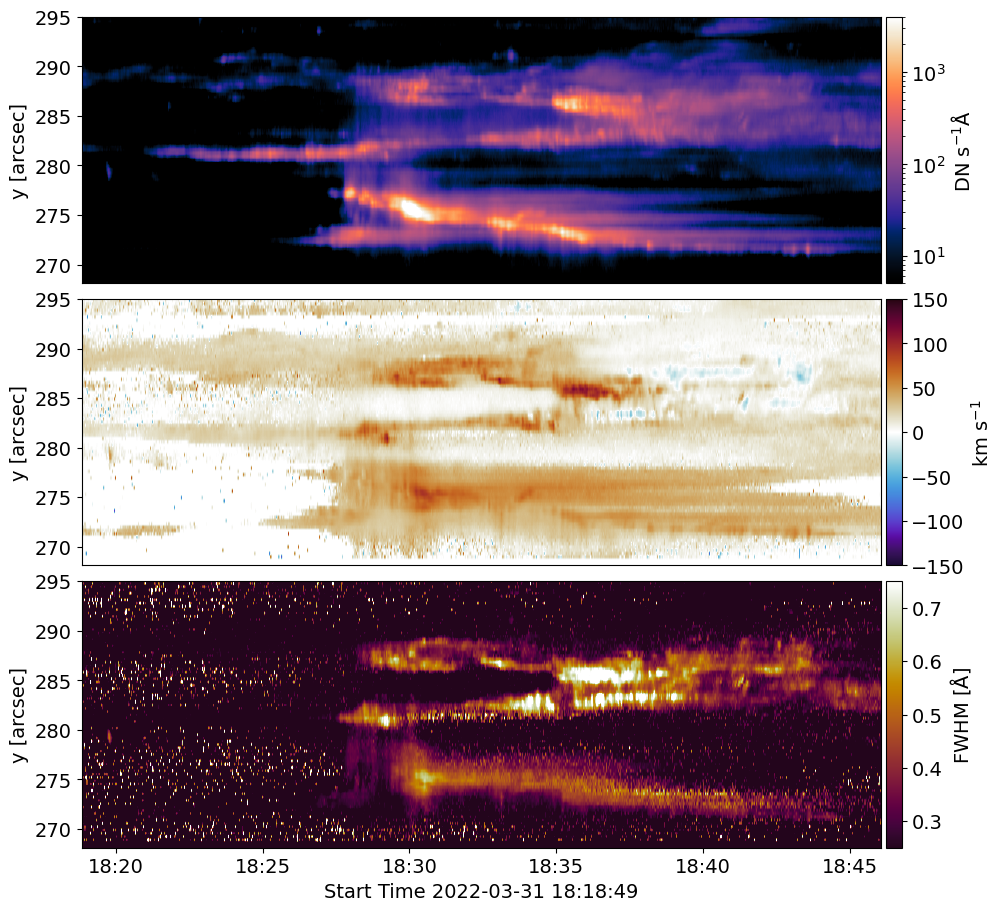

In [20]:
fig8 = plt.figure(figsize=(9, 9),constrained_layout=True)
gs1 = fig8.add_gridspec(nrows=3, ncols=1, wspace=0.0,hspace=0.)

ax0 = fig8.add_subplot(gs1[0,:])
ax1 = fig8.add_subplot(gs1[1,:])
ax2 = fig8.add_subplot(gs1[2,:])

# =================================================================

im = ax0.imshow(m0,origin='lower',norm=LogNorm(vmin=5, vmax=4000),cmap=cmr.torch,aspect='auto',
          extent=[tm_iris[0],tm_iris[-1],arcsec[0],arcsec[-1]])

# color bar
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('DN s$^{-1} \mathrm{\AA}$')

# date stuff
ax0.xaxis_date()
date_format = date.DateFormatter('%H:%M')
ax0.xaxis.set_major_formatter(date_format)
ax0.set_ylim(top=295)

ax0.xaxis.set_visible(False)
ax0.xaxis.set_ticklabels([])

# =================================================================

im = ax1.imshow(vel ,vmin=-150, vmax=150, origin='lower',aspect='auto',cmap=cmr.fusion_r,
          extent=[tm_iris[0],tm_iris[-1],arcsec[0],arcsec[-1]])

# color bar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('km s$^{-1}$')

# date stuff
ax1.xaxis_date()
date_format = date.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(date_format)
ax1.set_ylim(top=295)
ax1.xaxis.set_visible(False)
ax1.xaxis.set_ticklabels([])

# =================================================================


im = ax2.imshow(fwhm ,vmin=0.25, vmax=0.75, origin='lower',aspect='auto',cmap=cmr.fall     ,
          extent=[tm_iris[0],tm_iris[-1],arcsec[0],arcsec[-1]])

# color bar
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('FWHM [$\mathrm{\AA}$]')

# date stuff
ax2.xaxis_date()
date_format = date.DateFormatter('%H:%M')
ax2.xaxis.set_major_formatter(date_format)
ax2.set_ylim(top=295)
ax2.set_xlim(left=tm_iris[0])

t0 = date.num2date(tm_iris[0])
ax2.set_xlabel("Start Time "+t0.strftime('%Y-%m-%d %H:%M:%S'))

ax0.set_ylabel('y [arcsec]')
ax1.set_ylabel('y [arcsec]')
ax2.set_ylabel('y [arcsec]')

#ax0.axhline(arcsec[143])



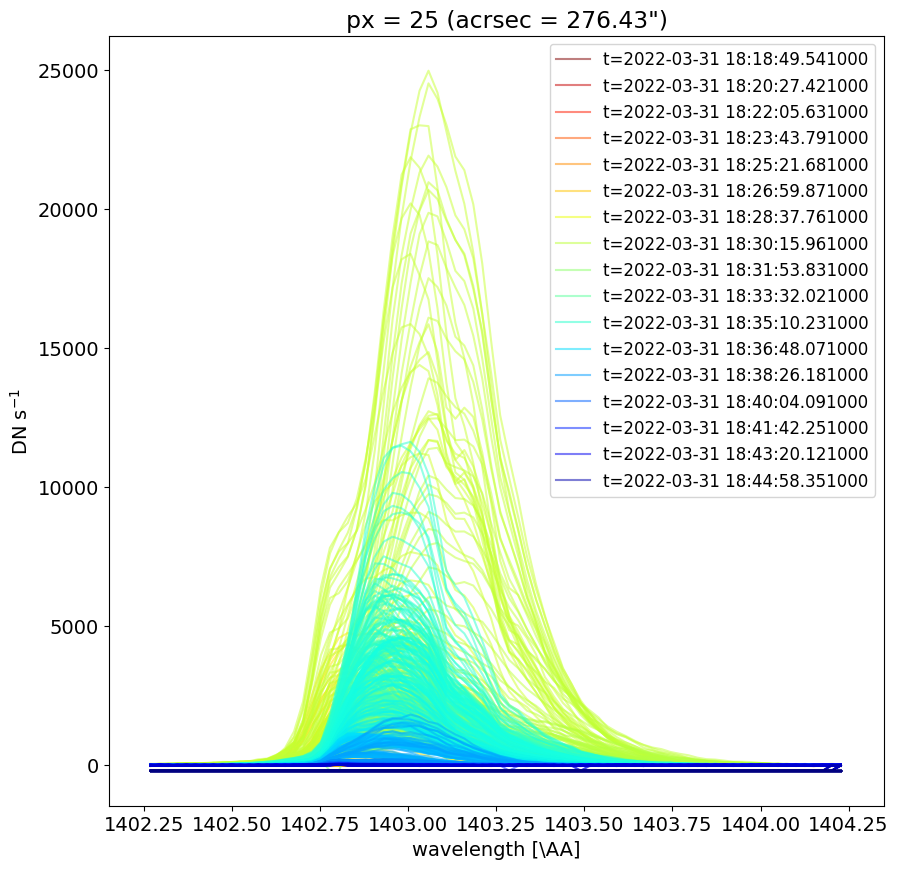

In [25]:
tms = np.arange(0,2001)
ns = len(tms)
colors = plt.cm.jet_r(np.linspace(0, 1, ns))


fig, ax = plt.subplots(figsize=(10,10))   
for i,t in enumerate(tms):
    
    tstr = 't='+str(datetime.strptime(time_iris[t].decode("utf-8"), '%Y-%m-%dT%H:%M:%S.%f'))
    
    if i%120==0:
        ax.plot(lam,siiv[y_coords[i],t],label=tstr,color=colors[i],alpha=0.5)
    else:
        ax.plot(lam,siiv[y_coords[i],t],color=colors[i],alpha=0.5)
    
ax.legend(loc=0,fontsize=12)
ax.set_xlim(1402.15,1404.35)
plt.title(f'   px = {px+1:.0f} (acrsec = {arcsec[px+1]:.2f}")')

ax.set_ylabel('DN s$^{-1}$')
ax.set_xlabel('wavelength [\AA]')

#cbar.ax.tick_params(colors='white')
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)
ax.tick_params(axis='x')
ax.tick_params(axis='y')

In [48]:
result = np.zeros((2001, 78))


for t in range(y_coords.shape[0]):
    y = y_coords[t]
    
    result[t, :] = siiv[y, t, :]


In [54]:
y_indices = np.asarray(y_coords, dtype=int)
time_indices = np.arange(2001)

result2 = siiv[y_indices, time_indices, :]

In [62]:
siiv_s = np.copy(result)
siiv_s[siiv_s<1.0]=1.0 # for clean log-scale plotting

(19082.76685672454, 19082.780093993057)

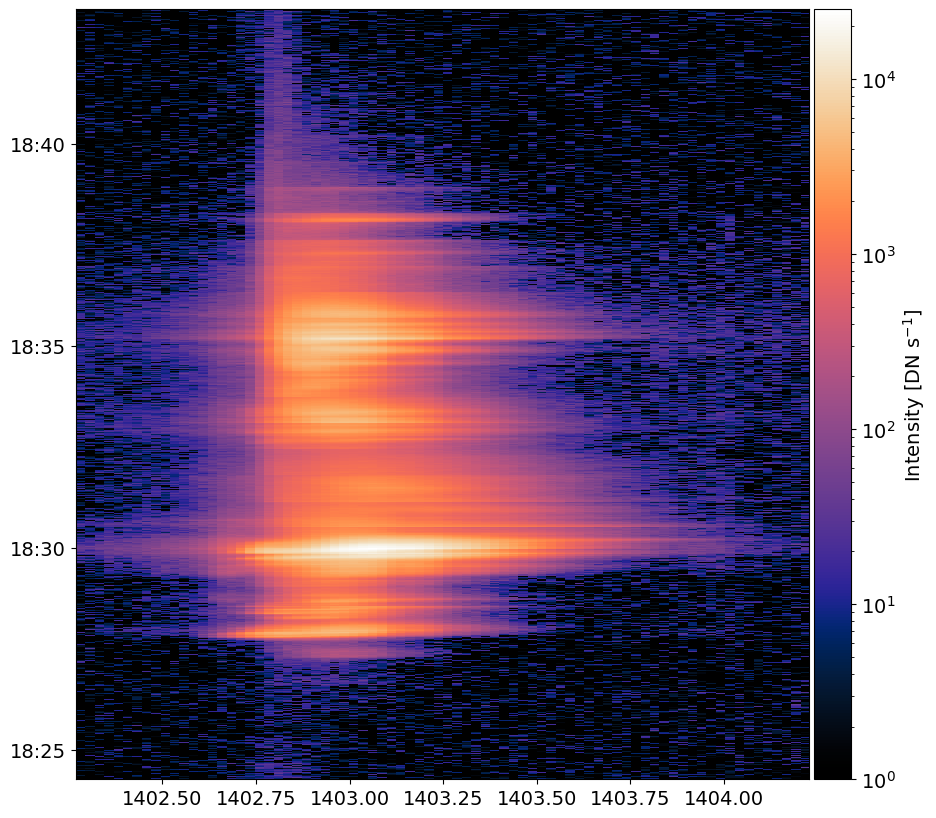

In [87]:
fig, ax = plt.subplots(figsize=(10,10))   
im = ax.imshow(siiv_s , norm=LogNorm(), origin='lower',aspect='auto',cmap=cmr.torch,interpolation='none',
              extent=[lam[0],lam[-1],tm_iris[0],tm_iris[-1]])


# color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Intensity [DN s$^{-1}$]')

# date stuff
ax.yaxis_date()
date_format = date.DateFormatter('%H:%M')
ax.yaxis.set_major_formatter(date_format)

#y_chng, = np.where(np.diff(y_coords)<0)
#for ys in y_chng:
#    ax.axhline(tm_iris[ys],alpha=0.5)

ax.set_ylim(tm_iris[400],tm_iris[1800])